In [1]:
import numpy as np
import pickle
from tqdm.auto import tqdm
import seaborn as sns
import pandas as pd
from importlib import reload
import matplotlib.pyplot as plt
import tools.dataTools as dt
from constants import Constants
import figure_params
import os
import pyaldata as pyal
from textwrap import wrap
import matplotlib.ticker as ticker
import scipy
figure_params.set_rc_params()

if not os.path.exists(Constants.FIG_FOLDER):
    os.makedirs(Constants.FIG_FOLDER)

SUBFIG_DIR = Constants.FIG_FOLDER + 'figS12_sweep/'
if not os.path.exists(SUBFIG_DIR):
    os.makedirs(SUBFIG_DIR)

# #run simulations for figure, will take a while to run
# import subprocess
# os.chdir(Constants.PROJ_DIR)
# subprocess.run(["bash", "simulation/fig_simulations/Sfig_sweep.sh"])


<module 'tools.dataTools' from '/home/jcc319/structure_proj/tools/dataTools.py'>

### Parameters

In [2]:
seeds = Constants.SEEDS
reps = Constants.UNIS
perturbation = Constants.PERT_ROTATION
pert_param = 10.0
pert_set = 'v1'

config_nums = [None] + list(range(1, 14)) + list(range(16, 24))

# figure params for all plots
figsize = (32, 4)
ncols = int(len(config_nums)/2)
nrows = 2

hyperparameters = [
    'Nonlinearity\n$\it{tanh}$',
    'Number of units\n$\it{N=300}$',
    'Initial rec wgt\n$\it{g=1.2}$',
    'Initial input wgt \n$\it{B \sim \mathcal{U}(-0.1, 0.1)}$',
    'Initial output wgt \n$\it{W \ sim \mathcal{U}(-0.1, 0.1)}$',
    'Noise\n$\it{\eta \sim \mathcal{N}(0,0.2)}$',
    'Weight regularization\n$\it{\\alpha=0.001}$',
    'Rate regularization\n$\it{\\beta=0.5}$',
    'Training trials\n$\it{750}$',
    'Batch size\n$\it{B=64}$',
    'Learning rate\n$\it{l=10^{-4}}$'
]

new_hyperparameters = [
    '$\it{tanh}$',
    '$\it{ReLU}$',
    '$\it{N=100}$',
    '$\it{N=500}$',
    '$\it{g=0.8}$',
    '$\it{g=1.6}$',
    '$\it{B \sim \mathcal{U}(-0.01, 0.01)}$',
    '$\it{B \sim \mathcal{U}(-1.0, 1.0)}$',
    '$\it{B \sim \mathcal{U}(-0.01, 0.01)}$',
    '$\it{B \sim \mathcal{U}(-1.0, 1.0)}$',
    '$\it{\eta=0}$',
    '$\it{\eta \sim \mathcal{N}(0,0.4)}$',
    '$\it{\\alpha=0.0001}$',
    '$\it{\\alpha=0.01}$',
    '$\it{\\beta=0.2}$',
    '$\it{\\beta=0.8}$',
    '$\it{500}$',
    '$\it{1000}$',
    '$\it{B=32}$',
    '$\it{B=128}$',
    '$\it{l=10^{-5}}$',
    '$\it{l=10^{-3}}$'
]

### Variance 

In [3]:
sim_set = 'uni_rad'
datafile = 'uni_10.0_rad'
redo = False

fname = Constants.PROCESSED_DATA_FOLDER + sim_set + '/' + \
    'repertoire_comparison_measures_norm_sweep.pickle'
if os.path.isfile(fname) & (not redo):
    with open(fname, 'rb') as f:
        measures_df = pickle.load(f)
else:
    # calculate variance for unit activity, latent activity, position, and angle
    rows_list = []
    for config_num in tqdm([None] + list(range(1, 24))):
        for seed in seeds:
            for repertoire in reps:
                # get simulation data
                exec_df = dt.get_pyaldata(sim_set, seed, repertoire, config_num=config_num,
                                          epoch_fun=Constants.exec_epoch, subtract_mean=False, datafile=datafile, calculate_kinematics=True)
                exec_df = dt.perform_pca(exec_df, Constants.PCA_DIMS)
                prep_exec_df = dt.get_pyaldata(
                    sim_set, seed, repertoire, config_num=config_num, epoch_fun=Constants.prep_exec_epoch, subtract_mean=False, datafile=datafile)
                prep_exec_df = dt.perform_pca(prep_exec_df, Constants.PCA_DIMS)

                # calculate distances between timesteps (for normalization of latent spaces)
                av_df = pyal.trial_average(prep_exec_df, 'target_param')
                dist_tsteps = np.linalg.norm(
                    np.diff(av_df.both_pca.values.tolist(), axis=1), axis=2)

                # calculate variance #############
                var_rates = np.var(
                    prep_exec_df.MCx_rates.values, axis=0).flatten()
                var_pca = np.var(prep_exec_df.both_pca.values /
                                 np.median(dist_tsteps), axis=0).flatten()
                var_pos = np.var(exec_df.pos.values, axis=0).flatten()

                temp = {
                    'seed': seed,
                    'repertoire': repertoire,
                    'config_num': config_num,
                    'var_rates': var_rates,
                    'var_pca': var_pca,
                    'var_pos': var_pos,
                }

                rows_list.append(temp)

    measures_df = pd.DataFrame(rows_list)
    with open(fname, 'wb') as f:
        pickle.dump(measures_df, f)

### Comparison measures

In [4]:
def compare_simsets(ax, data, reps, perturbation, config_num, y):
    line_colors = ['grey', 'lightgrey']
    line_styles = ['solid', 'dashed']

    for i, sim_set in enumerate(['uni_rad', 'uni_onehot']):

        moveset = dt.get_moveset(reps[0])
        abr_dict = Constants.REPERTOIRE_ABR_DICTS[moveset]

        if config_num is None:
            df = data[(data.sim_set == sim_set) & (data.perturbation == perturbation) & (
                data.config_num.isna()) & (data.repertoire.isin(reps))]
        else:
            df = data[(data.sim_set == sim_set) & (data.perturbation == perturbation) & (
                data.config_num == config_num) & (data.repertoire.isin(reps))]

        colors = Constants.REPERTOIRE_COLORS[1:]
        g = sns.swarmplot(x="repertoire", y=y, data=df, palette=colors,
                          alpha=0.4, marker='o' if i == 0 else '^', ax=ax, order=reps, size=4)
        g = dt.pointplot_across_repertoires(
            df, reps, y, line_colors[i], line_styles[i], ax=ax)
    return g

#### Fit exponential

In [5]:
# exponential function
def exp_func(t, A, K, C):
    return A * np.exp(K * t) + C


smooth = True
learn_set = None
perturbation = 'rotation'
pert_param = 10.0
pert_set = 'v1'
redo = False

reps = Constants.UNIS

info = '_'.join([perturbation, str(pert_param), pert_set])
fname = Constants.PROCESSED_DATA_FOLDER + f'decay_across_sweep_{info}.pickle'

if os.path.exists(fname) & (not redo):
    with open(fname, 'rb') as f:
        decay_df = pickle.load(f)
else:

    rows_list = []
    colormap = dt.get_colormap(reps, 'plasma_r')
    for sim_set in ['uni_rad', 'uni_onehot']:
        for seed in seeds:
            for config_num in config_nums:
                for repertoire in reps:

                    # decay constant
                    try:
                        loss = dt.get_loss(seed, sim_set, repertoire, perturbation,
                                           pert_param, pert_set, config_num=config_num, smooth=smooth)

                        t = np.arange(1, len(loss)+1)
                        # exponential fit
                        p0 = (0.1, -0.1, 0.2)  # starting search koefs
                        opt, pcov = scipy.optimize.curve_fit(
                            exp_func, t, loss, p0)
                        A, K, C = opt
                        fit_y = exp_func(t, A, K, C)
                    except:
                        print('failed', seed, sim_set, repertoire, config_num)
                        decay = np.nan
                        continue

                    # relative weight change
                    outdir = dt.get_outdir(
                        seed, sim_set, repertoire, perturbation, pert_param, pert_set, config_num=config_num)
                    init_weights = dt.get_model_weights(
                        outdir, before_training=True)['rec']
                    dws = dt.get_weight_changes(outdir)['rec']
                    rel_dw = dt.rel_dw(dws, init_weights)
                    rel_dw_med_abs = np.median(np.abs(rel_dw))

                    temp = {
                        'seed': seed,
                        'sim_set': sim_set,
                        'repertoire': repertoire,
                        'perturbation': perturbation,
                        'pert_param': pert_param,
                        'pert_set': pert_set,
                        'decay': K,
                        'rel_dw_med_abs': rel_dw_med_abs,
                        'config_num': config_num,
                    }
                    rows_list.append(temp)

    decay_df = pd.DataFrame(rows_list)
    with open(fname, 'wb') as f:
        pickle.dump(decay_df, f)

#### Deviation angle

In [6]:
import pyaldata as pyal
from sklearn.decomposition import PCA
import math

# params
redo = False
perturbation = 'rotation'
pert_set = 'v1'
pert_param = 10.0
repertoires = Constants.UNIS

for sim_set in ['uni_rad', 'uni_onehot']:
    fname = Constants.PROCESSED_DATA_FOLDER + \
        sim_set + '/deviation_angle_sweep.pickle'
    if redo or (not os.path.isfile(fname)):
        rows_list = []
        for seed in tqdm(seeds):
            for config_num in (config_nums):
                for j, repertoire in enumerate(repertoires[1:]):

                    # activity during skill learning
                    skill_df = dt.get_pyaldata(sim_set, seed, repertoire, config_num=config_num,
                                               epoch_fun=Constants.prep_exec_epoch, subtract_mean=False)
                    model = pyal.fit_dim_reduce_model(
                        skill_df, PCA(Constants.PCA_DIMS), 'MCx_rates')
                    skill_df = pyal.apply_dim_reduce_model(
                        skill_df, model, 'MCx_rates', 'both_pca')
                    skill_av_df = pyal.trial_average(skill_df, 'target_param')
                    skill_av_df = skill_av_df.sort_values(
                        by='target_param', ascending=False)  # sort movements

                    # activity during adaptation
                    pert_df = dt.get_pyaldata(sim_set, seed, repertoire, perturbation, pert_param, pert_set, config_num=config_num,
                                              epoch_fun=Constants.prep_exec_epoch, subtract_mean=False)
                    pert_df = pyal.apply_dim_reduce_model(
                        pert_df, model, 'MCx_rates', 'both_pca')
                    pert_av_df = pyal.trial_average(pert_df, 'target_param')
                    pert_av_df = pert_av_df.sort_values(
                        by='target_param', ascending=False)

                    # get latent activity for first two reaches and reach after adaptation
                    skill_pca_reach1 = np.array(
                        skill_av_df.both_pca.values.tolist())[0]
                    skill_pca_reach2 = np.array(
                        skill_av_df.both_pca.values.tolist())[1]
                    pert_pca_reach1 = np.array(
                        pert_av_df.both_pca.values.tolist())[0]

                    # get adjacent movement vector (between adjacent reaches)
                    reach_diff = skill_pca_reach2 - skill_pca_reach1
                    reach_diff = np.array([x/np.linalg.norm(x)
                                          for x in reach_diff])

                    # get adaptation vector (between reaches before and after adaptation)
                    pert_diff = pert_pca_reach1 - skill_pca_reach1
                    pert_diff = np.array([x/np.linalg.norm(x)
                                         for x in pert_diff])
                    # ave_pert_diff = np.mean(pert_diff, axis = 0)

                    # get deviation angle: calc for each tstep
                    angle = np.degrees(np.arccos(
                        np.clip([np.dot(x, y) for x, y in zip(reach_diff, pert_diff)], -1.0, 1.0)))

                    temp = {
                        'seed': seed,
                        'sim_set': sim_set,
                        'repertoire': repertoire,
                        'perturbation': perturbation,
                        'pert_param': pert_param,
                        'pert_set': pert_set,
                        'adj_movement_vector': reach_diff,
                        'adaptation_vector': pert_diff,
                        'angle': angle,
                        'config_num': config_num,
                    }
                    rows_list.append(temp)

        angles_df = pd.DataFrame(rows_list)

        # plt.tight_layout()
        with open(fname, 'wb') as f:
            pickle.dump(angles_df, f)

with open(Constants.PROCESSED_DATA_FOLDER + 'uni_rad/deviation_angle_sweep.pickle', 'rb') as f:
    angles_df_rad = pickle.load(f)
with open(Constants.PROCESSED_DATA_FOLDER + 'uni_onehot/deviation_angle_sweep.pickle', 'rb') as f:
    angles_df_onehot = pickle.load(f)

angles_df = pd.concat([angles_df_rad, angles_df_onehot])
angles_df['dev_angle'] = angles_df.apply(
    lambda row: np.median(row.angle), axis=1)
angles_df['config_num'] = angles_df['config_num'].astype('Int64')

### Plot all measures

0.0009765625
0.998046875
0.1611328125
0.0009765625
0.0009765625
0.0009765625
0.0068359375
0.0009765625
0.34765625
0.9677734375
0.0009765625
0.0009765625
0.0009765625
0.0009765625
0.0009765625
0.0009765625
0.0009765625
0.0029296875
0.0009765625
0.0009765625
0.34765625
0.615234375


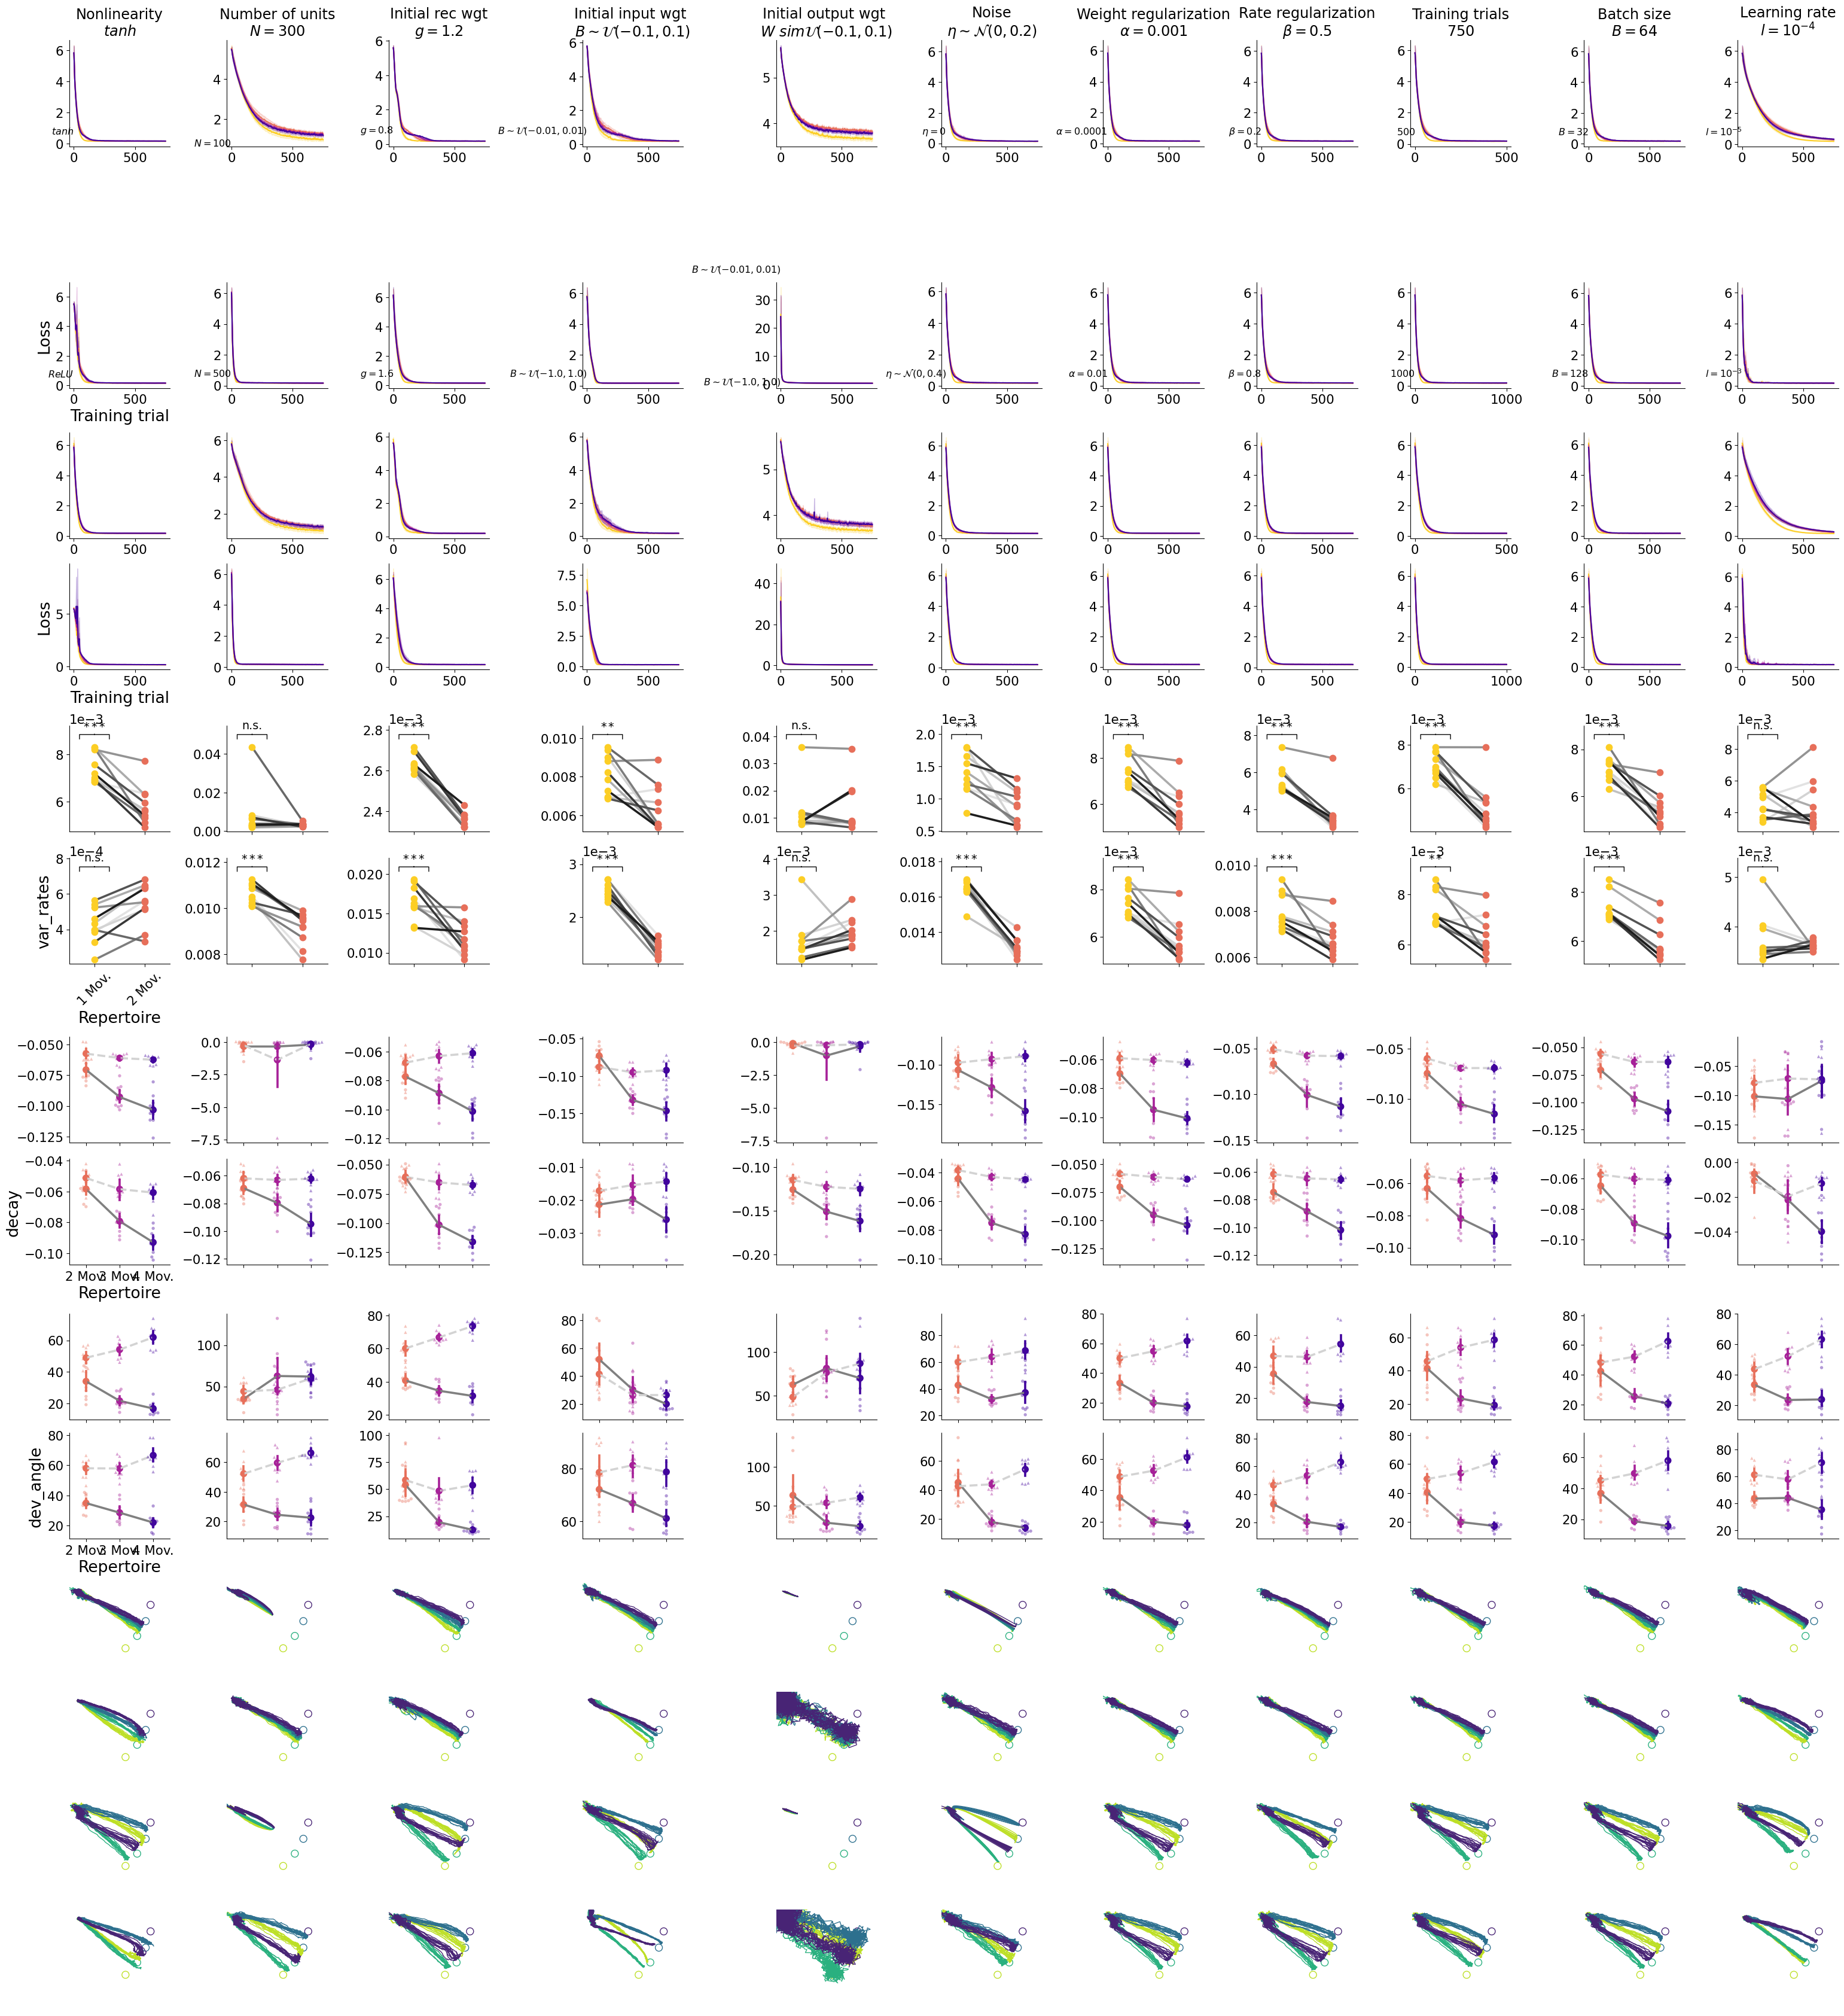

In [16]:
smooth = True

config_outliers = [9]
fig, axs = plt.subplots(nrows=nrows*7, ncols=ncols,
                        figsize=(32,35), constrained_layout=True)

# info about hyperparameters
for i, hyperparam in enumerate(hyperparameters):
    axs[0][i].set_title(hyperparam, fontsize=18)

for i, config_num in enumerate(config_nums):

    r = 0 if i%2 == 0 else 1
    c = int(i/2)

    # add text for hyperparam in top right corner
    axs[r][c].text(0.95, 0.8, new_hyperparameters[i],
                   fontsize=12, ha='right', va='center')

    # uni_rad loss
    g, params = dt.graph_loss(
        seeds, 'uni_rad', reps, config_num=config_num, smooth=smooth, rel_loss=False, ax=axs[r][c])
    if config_num not in config_outliers:
        axs[r][c].set_ylim([-0.5, 7])

    # uni_onehot loss
    g, params = dt.graph_loss(
        seeds, 'uni_onehot', reps, config_num=config_num, smooth=smooth, rel_loss=False, ax=axs[r+2][c])
    if config_num not in config_outliers:
        axs[r+2][c].set_ylim([-0.5, 7])

    # uni_rad variance
    if config_num is None:
        measures_df_ = measures_df[(measures_df.config_num.isna())].copy()
    else:
        measures_df_ = measures_df[(
            measures_df.config_num == config_num)].copy()
    g = dt.compare_measure(measures_df_, 'var_rates',
                           reps[:2], stats_alternative='greater', ax=axs[r+4][c], ci=None)
    if i != 1:
        axs[r+4][c].set_xticklabels([])

    # uni_rad decay
    try:
        g = compare_simsets(
            axs[r+6][c], decay_df, reps[1:], Constants.PERT_ROTATION, config_num, 'decay')
    except:
        print('failed', config_num)
        continue
    if i != 1:
        axs[r+6][c].set_xticklabels([])

    # uni_rad dev angle
    g = compare_simsets(
        axs[r+8][c], angles_df, reps[1:], Constants.PERT_ROTATION, config_num, 'dev_angle')
    if i != 1:
        axs[r+8][c].set_xticklabels([])

    # uni_rad reassoc output
    dt.graph_output(Constants.SEED_EX, 'uni_rad',
                    reps[-1], perturbation=Constants.PERT_REASSOCIATION, pert_param=0.0, pert_set='v1', config_num=config_num, ax=axs[r+10][c])

    # onehot reassoc output
    dt.graph_output(Constants.SEED_EX, 'uni_onehot',
                    reps[-1], perturbation=Constants.PERT_REASSOCIATION, pert_param=0.0, pert_set='v1', config_num=config_num, ax=axs[r+12][c])


for r in range(nrows*7):
    for c in range(ncols):
        if not ((r%2 == 1) and (c == 0)):
            axs[r][c].set_ylabel('')
            axs[r][c].set_xlabel('')

plt.savefig(SUBFIG_DIR + f"sweep_measures" +
            '.pdf', format='pdf', bbox_inches='tight')